In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import rcParams
import scipy.stats as stats 
import matplotlib.ticker as plticker
from scipy.optimize import curve_fit
import random
from rpy2.robjects import Vector
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import optimize

## PART I

**The model**: 

- Randomly selects 9 (out of 11) observations of drainage area and baseflow discharge 

- Runs a linear regression fit to the data, **with an intercept defined at the origin**

- Iterates the process 1000 times and generates an average fit

In [2]:
#Generate df of the observations
#DA is in km^2 and Q is in l/s
d={'DA':[0.0825, 0.0272, 0.0163, 0.117, 0.383,
         1.6, 0.128, 0.0095, 2.61, 3.37, 0.0029], 
                             'Q':[7.5342, 0.5916, 0.87, 3.6,
                              7.995, 24.09, 8.04, 0.94,
                              119.53, 236.5, 0.05]}
df = pd.DataFrame(data=d, dtype=float)
#df

In [3]:
#randomly select a subset of the df
def some(foo, n):
    return foo.iloc[random.sample(foo.index, n)]
#some(df,9)

In [4]:
# make a new df to store values
runs = pd.DataFrame(columns=['obs_da','obs_val', 'pred_val','residual','slope','r2','id'])

for e in range(1000):
    #selects a random sample
    k = some(df,9)

    xdata = np.array(k['DA'])
    ydata = np.array(k['Q'])

    #linear change in x with no intercept
    def func(x, m):
        return (m*x)
    
    #find params
    popt, pcov = optimize.curve_fit(func, xdata, ydata)

    # Model fit
    x_lin = np.linspace(0, xdata.max(), 50)
    y_model = func(x_lin, popt)

    # MODEL OUTPUT -----------------------------------------------------------------
    obs_values = ydata
    pred_values = []
    residuals = []
    obs_da = xdata
    slope = []

    #calculates the predicted values from the power law fit estimated params
    for i in xdata:
        pred_i = (i * popt)
        pred_slope = float(popt)
        pred_values.append(float(pred_i))
        slope.append(pred_slope)
    
    # RESIDUALS -------------------------------------------------------------------    
    residuals = ydata - func(xdata, popt)
    #residual sum of squares
    ss_res = np.sum(residuals**2)
    #total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    #r_squared value
    r_squared = 1 - (ss_res / ss_tot)
        
    temp_runs = pd.DataFrame()
    
    temp_runs['obs_da']=obs_da
    temp_runs['obs_val']=obs_values
    temp_runs['pred_val']=pred_values
    temp_runs['residual']=residuals
    temp_runs['slope']=slope
    temp_runs['r2']=r_squared
    temp_runs['id']=e
    
    runs = runs.append(pd.DataFrame(data=temp_runs))  

In [5]:
runs.describe()

,obs_da,obs_val,pred_val,residual,slope,r2
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,0.753594,37.168003,41.212553,-4.044550,53.628804,0.876773
std,1.151882,71.381866,64.671986,24.072714,9.346251,0.041246
min,0.002900,0.050000,0.046191,-71.952105,15.928066,0.816822
25%,0.016300,0.870000,0.971541,-3.539979,55.106237,0.858362
50%,0.117000,7.534200,6.446584,-0.109851,55.132814,0.860852
75%,1.600000,24.090000,88.167788,0.954109,59.619166,0.864057
max,3.370000,236.500000,234.226399,50.816329,69.503383,0.992159


In [6]:
#MEAN -------------------------------------------------------------------------------
tot_meanslope = runs['slope'].mean()

#Fit of average to the observed data
avg_residuals = ydata - func(xdata, tot_meanslope)
#residual sum of squares
avg_ss_res = np.sum(avg_residuals**2)
#total sum of squares
avg_ss_tot = np.sum((ydata-np.mean(ydata))**2)
#r_squared value
avg_r_squared = 1 - (avg_ss_res / avg_ss_tot)
#print avg_r_squared

#MEDIAN -------------------------------------------------------------------------------
tot_medianslope = runs['slope'].median()

#Fit of average to the observed data
med_residuals = ydata - func(xdata, tot_medianslope)
#residual sum of squares
med_ss_res = np.sum(med_residuals**2)
#total sum of squares
med_ss_tot = np.sum((ydata-np.mean(ydata))**2)
#r_squared value
med_r_squared = 1 - (med_ss_res / med_ss_tot)

In [7]:
#split by id
grouped = runs.groupby('id')

#create series with one value for slope, intercept, and r2
temp_slope = grouped['slope'].first()
temp_r = grouped['r2'].first()

#new data frame with slope, intercept, r2 stored by id
line_data = pd.concat([temp_slope, temp_r], axis=1)
line_data = pd.DataFrame(line_data, columns=('slope','r2'))
#line_data

In [8]:
for row in line_data:
    
    m = line_data['slope']
    
    y_values = [(m*x) for x in range(5)]
    x_values = np.arange(len(y_values))

('Average slope:', 53.62880405608287, 'R squared:', 0.8568574495634411)
('Median slope:', 55.13281364148618, 'R squared:', 0.8577408330536918)


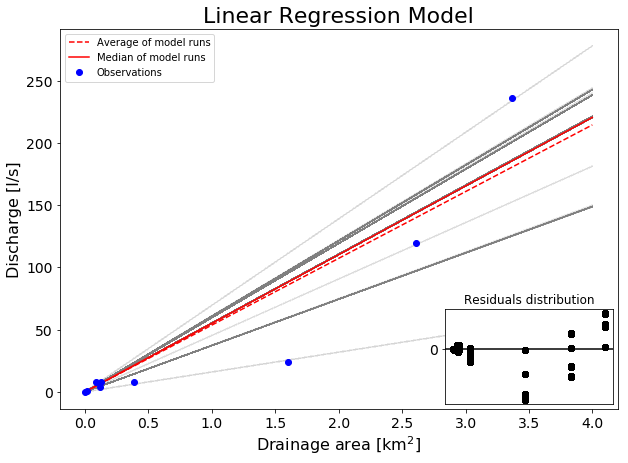

In [9]:
# PLOT -----------------------------------------------------------------------------
rcParams['figure.titlesize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.subplot.wspace'] = 0.2

print ("Average slope:", tot_meanslope, "R squared:", avg_r_squared)
print ("Median slope:", tot_medianslope, "R squared:", med_r_squared)

fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x_values, y_values, linestyle='-', color='grey', marker='', alpha=0.01)
plt.plot(x_values, (x_values*tot_meanslope), 'r--', 
         label='Average of model runs')
plt.plot(x_values, (x_values*tot_medianslope),'r', 
         label='Median of model runs')
plt.plot(xdata, ydata, marker='o', color='b', linestyle='', label='Observations')
plt.legend(loc="upper left")

axins = inset_axes(ax, width="30%", height="25%", loc=4)
axins.axhline(color='k')
axins.scatter(runs['obs_da'], runs['residual'], color='k')
axins.set_xticks([])
axins.set_yticks([0])
axins.set_title(label='Residuals distribution', fontsize='12')

ax.set_title('Linear Regression Model')
ax.set_xlabel('Drainage area [km$^2$]')
ax.set_ylabel('Discharge [l/s]')
plt.show()

## PART II

**Predicting the discharge** in channels where drainage area can be measured, but discharge cannot.

In [10]:
#df with all measured DAs
WSD = pd.read_csv('DA-QCalc.csv') 
DA = WSD['DA km^2']

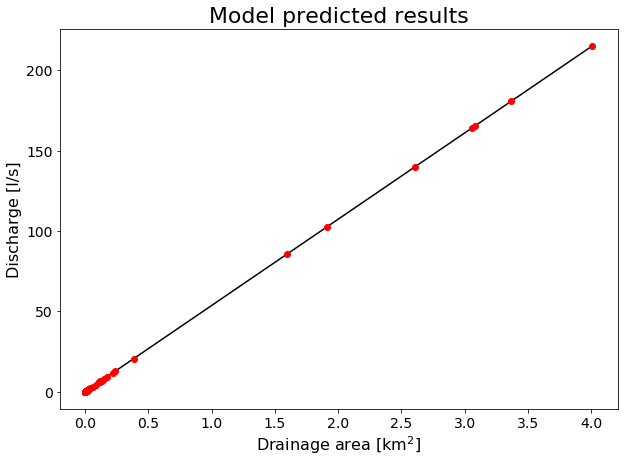

In [11]:
pred_Q = []

#Using the mean
for d in DA:
    pred_d = float(d) * float(tot_meanslope)
    pred_Q.append(pred_d)
    
#PLOT ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x_values, (x_values*tot_meanslope), color='k', 
         label='Mean of model runs')
plt.plot(DA, pred_Q, marker='o', color='r', linestyle='')

ax.set_title('Model predicted results')
ax.set_xlabel('Drainage area [km$^2$]')
ax.set_ylabel('Discharge [l/s]')

plt.show()

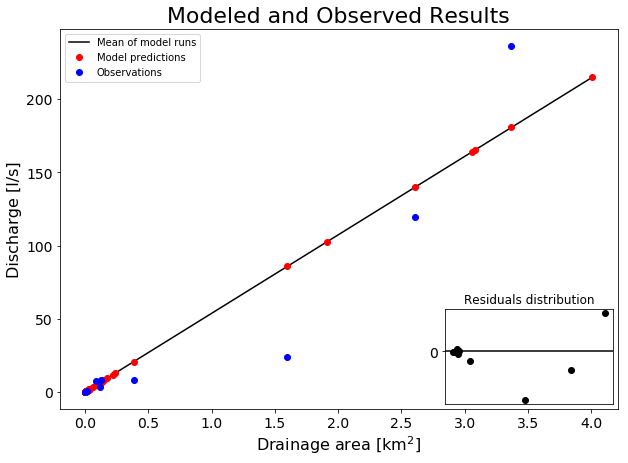

In [12]:
fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x_values, (x_values*tot_meanslope), color='k', 
         label='Mean of model runs')
plt.plot(DA, pred_Q, marker='o', color='r', linestyle='',label='Model predictions')
plt.plot(xdata, ydata, marker='o', color='b', linestyle='', label='Observations')
plt.legend(loc='upper left')

axins = inset_axes(ax, width="30%", height="25%", loc=4)
axins.axhline(color='k')
axins.scatter(xdata, med_residuals, color='k')
axins.set_xticks([])
axins.set_yticks([0])
axins.set_title(label='Residuals distribution', fontsize='12')

ax.set_title('Modeled and Observed Results')
ax.set_xlabel('Drainage area [km$^2$]')
ax.set_ylabel('Discharge [l/s]')

plt.show()

('Average slope:', 53.62880405608287, 'R squared:', 0.8568574495634411)


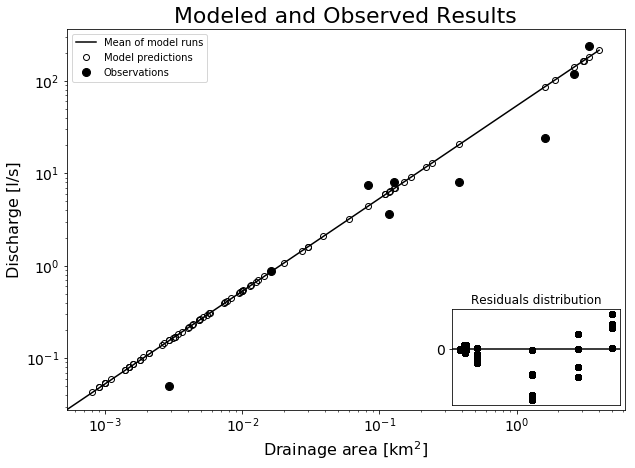

In [13]:
#Figure for paper:
fig, ax = plt.subplots(figsize=(10,7))

print ("Average slope:", tot_meanslope, "R squared:", avg_r_squared)

plt.loglog(x_values, (x_values*tot_meanslope), color='k', 
         label='Mean of model runs')
plt.loglog(DA, pred_Q, marker='o', color='k', fillstyle='none', linestyle='',label='Model predictions')
plt.loglog(xdata, ydata, marker='o', color='k', markersize=8, linestyle='', label='Observations')
plt.legend(loc='upper left')

axins = inset_axes(ax, width="30%", height="25%", loc=4)
axins.axhline(color='k')
axins.scatter(runs['obs_da'], runs['residual'], color='k')
axins.set_xticks([])
axins.set_yticks([0])
axins.set_title(label='Residuals distribution', fontsize='12')

ax.set_title('Modeled and Observed Results')
ax.set_xlabel('Drainage area [km$^2$]')
ax.set_ylabel('Discharge [l/s]')

plt.savefig('DischargePredictions.png')
plt.show()

Suggested final product:

Average of 1000 iterations of a linear model on randomly subsampled data. Slope ~54 and R^2 ~0.86. Residuals for model runs plotted in the inset

In [28]:
#DATAFRAME OF PREDICTED DISCHARGES -------------------------------------------------
pred_Q = np.array(pred_Q)
lnr_df = pd.DataFrame(columns=['Drainage area [km$^2$]','Modeled Q [l/s]',
                               'Modeled Q [cm$^3$/s]','Observed Q [l/s]',
                              'Catchment', 'Type', 'Erosion rate', 'Uncertainty'])
lnr_df['Drainage area [km$^2$]']=DA
lnr_df['Modeled Q [l/s]']=pred_Q
lnr_df['Modeled Q [cm$^3$/s]']=pred_Q*1000
lnr_df['Observed Q [l/s]']=df['Q']
lnr_df['Catchment']=WSD['Catchment']
lnr_df['Type']=WSD['Type']
lnr_df['Erosion rate']=WSD['Erosion rate m/My']
lnr_df['Uncertainty']=WSD['Erosion uncertainty m/My']
lnr_df.to_csv('lnr_baseflow_predictions.csv')

## PART III
*Adding in the **cosmo erosion rates**:*

- Does the erosion rate increase as a function of the baseflow discharge?
- Is this relationship different for seepage channels vs. fluvial channels?




In [47]:
Seeps = lnr_df.loc[lnr_df['Type'] == 'Seep']
Fluvial = lnr_df.loc[lnr_df['Type'] == 'Fluvial']

cosmo_fluv = Fluvial['Erosion rate']
Q_fluv = Fluvial['Modeled Q [l/s]']

cosmo_seep = Seeps['Erosion rate']
Q_seep = Seeps['Modeled Q [l/s]']
Seep_error = Seeps['Uncertainty'].dropna()
print "Min seep Q:", Seeps['Modeled Q [l/s]'].min()
print "Max seep Q:", Seeps['Modeled Q [l/s]'].max()

Min seep Q: 0.042903043244866296
Max seep Q: 4.424376334626837


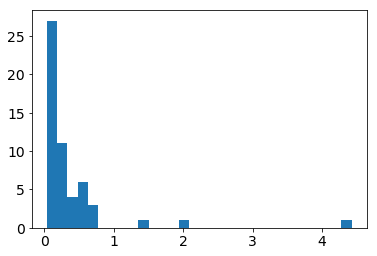

In [43]:
plt.hist(Q_seep, bins=30)
plt.show()

Running a linear regression on the datasets for the two channel types:

In [17]:
#df of fluvial channels
df_fl = pd.concat([cosmo_fluv, Q_fluv], axis=1).dropna().reset_index(drop=True)
#df of sapping channels
df_gw = pd.concat([cosmo_seep, Q_seep], axis=1).dropna().reset_index(drop=True)

In [18]:
xf = df_fl['Modeled Q [l/s]']
yf = df_fl['Erosion rate']

fslope, fintercept, fr_value, fp_value, fstd_err = stats.linregress(xf,yf)
print ("Fluvial channel group, estimated slope:", fslope)
print ("Fluvial channel group, estimated r^2:", fr_value**2)

xg = df_gw['Modeled Q [l/s]']
yg = df_gw['Erosion rate']

gslope, gintercept, gr_value, gp_value, gstd_err = stats.linregress(xg,yg)

print ("Seepage channel group, estimated slope:", gslope)
print ("Seepage channel group, estimated r^2:", gr_value**2)


('Fluvial channel group, estimated slope:', 0.3893189295263066)
('Fluvial channel group, estimated r^2:', 0.1776291323085956)
('Seepage channel group, estimated slope:', 22.041549242540224)
('Seepage channel group, estimated r^2:', 0.8709801445062102)


In [19]:
#to plot a nice linear function on the graph
#seepage channel samples
for row in df_gw:
    
    m = fslope
    b = fintercept
    
    y_g = [(m*x)+b for x in range(6)]
    x_g = np.arange(len(y_g))

In [20]:
#to plot a nice linear function on the graph
#other channel samples
for row in df_fl:
    
    m = fslope
    b = fintercept
    
    y_f = [(m*x)+b for x in range(300)]
    x_f = np.arange(len(y_f))

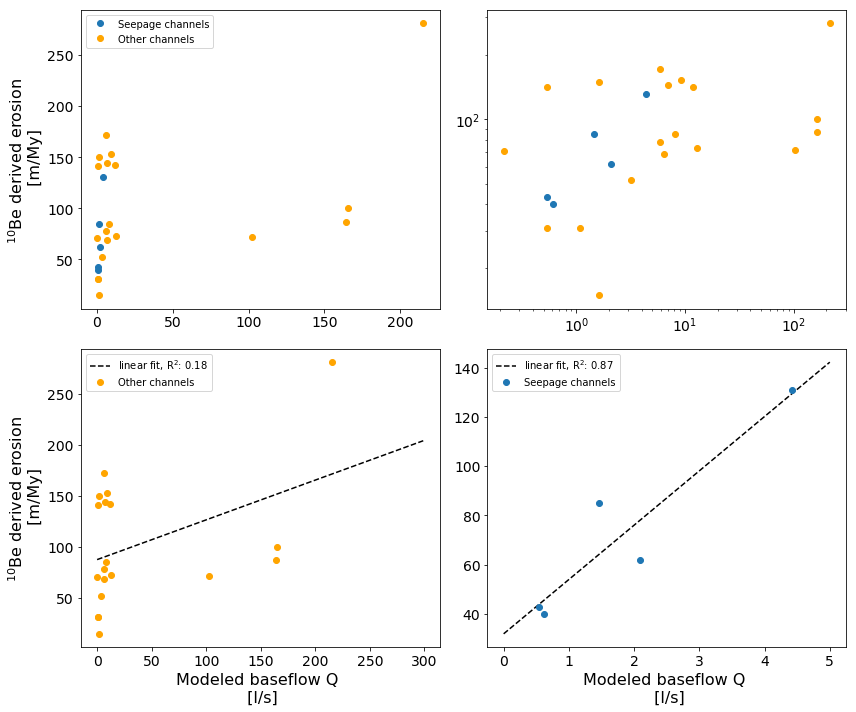

In [22]:
#Just looking:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10))

ax1.plot(Q_seep, cosmo_seep, marker='o', linestyle='',label='Seepage channels')
ax1.plot(Q_fluv,cosmo_fluv,  marker='o', color='orange', linestyle='', label='Other channels')
ax1.set_ylabel('$^{10}$Be derived erosion \n [m/My]')
ax1.legend(loc='upper left')

ax2.loglog(Q_seep, cosmo_seep, marker='o', linestyle='',label='Seepage channels')
ax2.loglog(Q_fluv,cosmo_fluv,  marker='o', color='orange', linestyle='',label='Other channels')

ax3.plot(x_f, (x_f*fslope)+fintercept, 'k--', label='linear fit, R$^2$: 0.18')
ax3.plot(xf, yf, marker='o', color='orange', linestyle='', label='Other channels')
ax3.set_ylabel('$^{10}$Be derived erosion \n [m/My]')
ax3.set_xlabel('Modeled baseflow Q \n [l/s]')
ax3.legend(loc='upper left')

ax4.plot(x_g, (x_g*gslope)+gintercept, 'k--', label='linear fit, R$^2$: 0.87')
ax4.plot(xg, yg, marker='o', linestyle='', label='Seepage channels')
ax4.set_xlabel('Modeled baseflow Q \n [l/s]')
ax4.legend(loc='upper left')

#plt.suptitle('Erosion rate vs. baseflow discharge', y='.94')
#plt.savefig('ErosionVSDischarge.png')
plt.tight_layout()
plt.show()

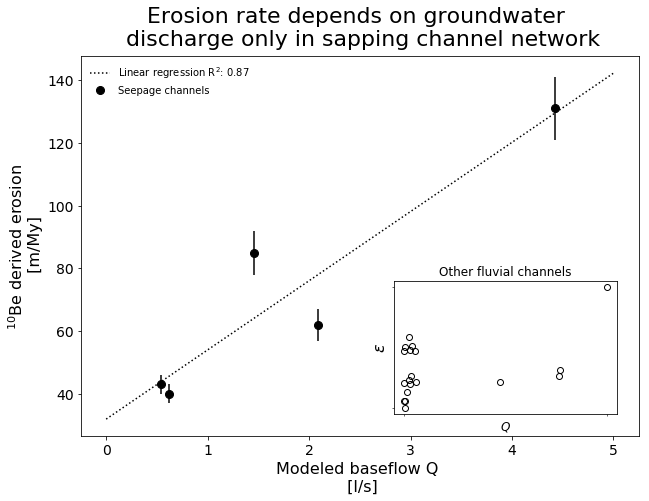

In [37]:
#Figure for paper:
fig, ax = plt.subplots(figsize=(10,7))

yerr = Seep_error

plt.plot(x_g, (x_g*gslope)+gintercept, 'k:', label='Linear regression R$^2$: 0.87')
plt.plot(xg, yg, marker='o', color='k', markersize=8, linestyle='', label='Seepage channels')
plt.errorbar(xg, yg, yerr=yerr, xerr=None, ls='', label=None, color='k')

plt.ylabel('$^{10}$Be derived erosion \n [m/My]')
plt.xlabel('Modeled baseflow Q \n [l/s]')
plt.legend(loc='upper left', frameon=False)
plt.title('Erosion rate depends on groundwater \n discharge only in sapping channel network', 
          pad=10)

axins = inset_axes(ax, width="40%", height="35%", loc=4, borderpad=2.2)
axins.plot(Q_fluv,cosmo_fluv, color='k',marker='o', fillstyle='none', linestyle='')
axins.set_title(label='Other fluvial channels', fontsize='12')
axins.set_xticks([])
axins.set_yticks([])

xlabels = ['0.2','218'] #either set the min/max values or assign an index name
q = [Q_fluv.min(), Q_fluv.max()]
axins.set_xticks(q,q)
axins.set_xticklabels(xlabels, fontsize=10)
ylabels = ['15','280']
axins.set_xlabel(r'$Q$',labelpad=0, fontsize=12)
e = [cosmo_fluv.min(), cosmo_fluv.max()]
axins.set_yticks(e,e) #take out second e to add the numbers back in
axins.set_yticklabels(ylabels, fontsize=10)
axins.set_ylabel(r'$\varepsilon$',labelpad=0)#, labelpad=-15

plt.savefig('ErosionRate_Q.png')
plt.show()

## PART IV
Comparing the **minimum eroded volumes** from sapping channels to the modeled baseflow Q

In [25]:
chan_params = pd.read_csv('ChannelParameters_ver3.csv') #contains min eroded volume
new_df = pd.concat([chan_params.iloc[:,0], chan_params['min eroded vol (kg)'], WSD['ID']], axis=1).dropna().reset_index(drop=True)
#chan_params

('Estimated Parameters', array([ 2262.13353838,     3.60975033, -2909.18729566]))
('Power law R_value:', 0.8575142531151108)


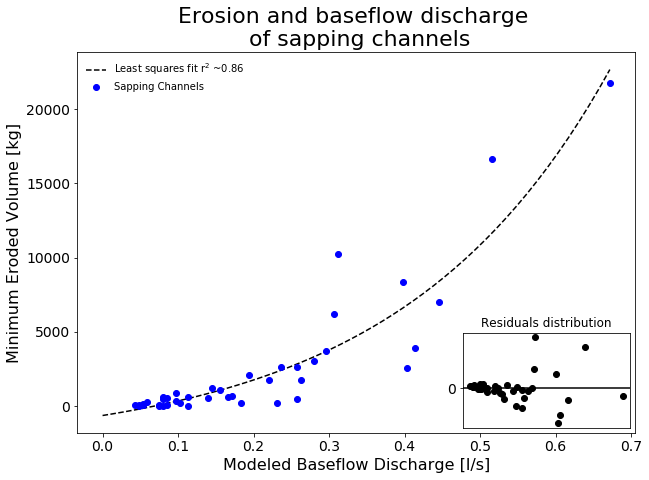

In [26]:
xdata = chan_params['Modeled Q (l/s)']
ydata = chan_params['min eroded vol (kg)']

#define general powerlaw equation
def func(x, N, a, d):
    return N*np.exp(a*x)+d

x_lin = np.linspace(0, xdata.max(), 50) # 50 evenly spaced digits between 0 and max

# REGRESSION ------------------------------------------------------------------
w, pcov = optimize.curve_fit(func, xdata, ydata)     
print("Estimated Parameters", w)  

# Model
y_model = func(x_lin, *w)

# MODEL OUTPUT -----------------------------------------------------------------
obs_values = ydata
pred_values = []
residuals = []

#calculates the predicted values from the power law fit estimated params
for i in xdata:
    pred_i = (w[0] * (np.exp(w[1]*(i)))+w[2])
    pred_values.append(pred_i)
    
# RESIDUALS -------------------------------------------------------------------    
residuals = ydata - func(xdata, w[0], w[1],w[2])
#residual sum of squares
ss_res = np.sum(residuals**2)
#total sum of squares
ss_tot = np.sum((ydata-np.mean(ydata))**2)
#r_squared value
r_squared = 1 - (ss_res / ss_tot)

print ("Power law R_value:", r_squared)

# PLOT --------------------------------------------------------------------------
rcParams['figure.titlesize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.subplot.wspace'] = 0.2

fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x_lin, y_model, "k--", label="Least squares fit r$^2$ ~0.86")
plt.plot(xdata, ydata, "bo", label="Sapping Channels")
#plt.plot(xdata, pred_values, "ro", label="Model Predictions")
plt.title("Erosion and baseflow discharge \n of sapping channels")
plt.legend(loc="upper left", frameon=False)
plt.xlabel('Modeled Baseflow Discharge [l/s]')
plt.ylabel('Minimum Eroded Volume [kg]')

axins = inset_axes(ax, width="30%", height="25%", loc=4)
axins.plot(xdata, residuals, linestyle='', marker='o', color='k')
axins.axhline(color='k')
axins.set_xticks([])
axins.set_yticks([0])
axins.set_title(label='Residuals distribution', fontsize='12')

#plt.savefig(fname='ErodedVol_Q_Powerlaw.png')
plt.show()

('Estimated Parameters', array([26527.04094561, -2657.1906788 ]))
('Linear regression R_value:', 0.7359777546099803)


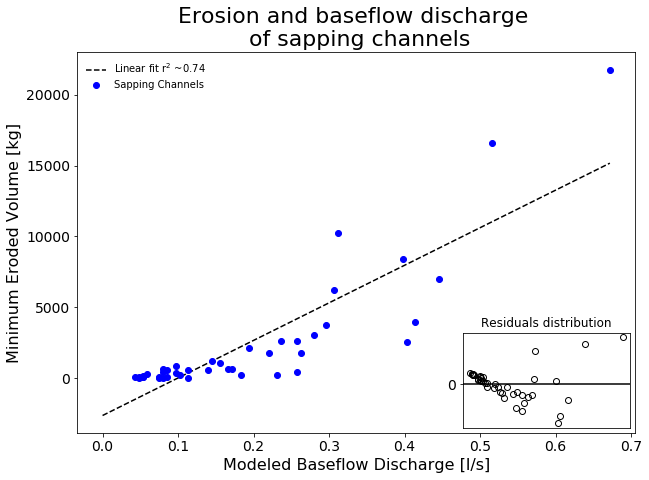

In [27]:
xdata = chan_params['Modeled Q (l/s)']
ydata = chan_params['min eroded vol (kg)']

def func(x, m, b):
    return (m*x)+b
    
#find params
popt, pcov = optimize.curve_fit(func, xdata, ydata)

x_lin = np.linspace(0, xdata.max(), 50) # 50 evenly spaced digits between 0 and max

# REGRESSION ------------------------------------------------------------------
w, pcov = optimize.curve_fit(func, xdata, ydata)     
print("Estimated Parameters", w)  

# Model
y_model = func(x_lin, *w)

# MODEL OUTPUT -----------------------------------------------------------------
obs_values = ydata
pred_values = []
residuals = []

#calculates the predicted values from the power law fit estimated params
for i in xdata:
    pred_i = (w[0]*i)+w[1]
    pred_values.append(pred_i)
    
# RESIDUALS -------------------------------------------------------------------    
residuals = ydata - func(xdata, w[0], w[1])
#residual sum of squares
ss_res = np.sum(residuals**2)
#total sum of squares
ss_tot = np.sum((ydata-np.mean(ydata))**2)
#r_squared value
r_squared = 1 - (ss_res / ss_tot)

print ("Linear regression R_value:", r_squared)

# PLOT --------------------------------------------------------------------------
rcParams['figure.titlesize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.subplot.wspace'] = 0.2

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(x_lin, y_model, "k--", label="Linear fit r$^2$ ~0.74")
ax.plot(xdata, ydata, "bo", label="Sapping Channels")
plt.title("Erosion and baseflow discharge \n of sapping channels")
plt.legend(loc="upper left", frameon=False)
plt.xlabel('Modeled Baseflow Discharge [l/s]')
plt.ylabel('Minimum Eroded Volume [kg]')

axins = inset_axes(ax, width="30%", height="25%", loc=4)
axins.plot(xdata, residuals, linestyle='', marker='o', color='k', fillstyle='none')
axins.axhline(color='k')
axins.set_xticks([])
axins.set_yticks([0])
axins.set_title(label='Residuals distribution', fontsize='12')

#plt.savefig(fname='ErodedVol_Q_Linear.png')
plt.show()